In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import torchvision
import torchvision.transforms as transforms
import numpy as np
%matplotlib inline
import random
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import sklearn as skl

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
from torchvision import models

In [ ]:
USE_CUDA = torch.cuda.is_available() # GPU를 사용가능하면 True, 아니라면 False를 리턴
device = torch.device("cuda" if USE_CUDA else "cpu") # GPU 사용 가능하면 사용하고 아니면 CPU 사용
print("다음 기기로 학습합니다:", device)

다음 기기로 학습합니다: cpu


In [ ]:
import os,sys
os.chdir("/gdrive/My Drive/Colab Notebooks/PyTorch/dlwpt-code-master")
path=os.getcwd()
path

'/gdrive/My Drive/Colab Notebooks/PyTorch/dlwpt-code-master'

In [ ]:
import imageio
img_arr = imageio.imread(path+'/data/p1ch4/image-dog/bobby.jpg')
print(img_arr.shape)
display(img_arr)

(720, 1280, 3)


Array([[[ 77,  45,  22],
        [ 77,  45,  22],
        [ 78,  46,  21],
        ...,
        [118,  78,  52],
        [117,  77,  51],
        [116,  76,  51]],

       [[ 75,  43,  20],
        [ 76,  44,  21],
        [ 77,  45,  20],
        ...,
        [118,  78,  52],
        [117,  77,  51],
        [116,  76,  50]],

       [[ 74,  39,  17],
        [ 75,  41,  16],
        [ 77,  43,  18],
        ...,
        [119,  80,  51],
        [117,  77,  51],
        [116,  76,  50]],

       ...,

       [[215, 165,  78],
        [216, 166,  79],
        [217, 167,  80],
        ...,
        [172, 122,  51],
        [174, 124,  53],
        [174, 124,  53]],

       [[215, 165,  78],
        [216, 166,  79],
        [217, 167,  80],
        ...,
        [173, 123,  54],
        [174, 124,  55],
        [174, 124,  55]],

       [[215, 165,  78],
        [216, 166,  79],
        [217, 167,  80],
        ...,
        [159, 108,  42],
        [158, 107,  41],
        [158, 107,  41]]

In [ ]:
img = torch.from_numpy(img_arr)
out = img.permute(2, 0, 1)
display(out,out.shape)

tensor([[[ 77,  77,  78,  ..., 118, 117, 116],
         [ 75,  76,  77,  ..., 118, 117, 116],
         [ 74,  75,  77,  ..., 119, 117, 116],
         ...,
         [215, 216, 217,  ..., 172, 174, 174],
         [215, 216, 217,  ..., 173, 174, 174],
         [215, 216, 217,  ..., 159, 158, 158]],

        [[ 45,  45,  46,  ...,  78,  77,  76],
         [ 43,  44,  45,  ...,  78,  77,  76],
         [ 39,  41,  43,  ...,  80,  77,  76],
         ...,
         [165, 166, 167,  ..., 122, 124, 124],
         [165, 166, 167,  ..., 123, 124, 124],
         [165, 166, 167,  ..., 108, 107, 107]],

        [[ 22,  22,  21,  ...,  52,  51,  51],
         [ 20,  21,  20,  ...,  52,  51,  50],
         [ 17,  16,  18,  ...,  51,  51,  50],
         ...,
         [ 78,  79,  80,  ...,  51,  53,  53],
         [ 78,  79,  80,  ...,  54,  55,  55],
         [ 78,  79,  80,  ...,  42,  41,  41]]], dtype=torch.uint8)

torch.Size([3, 720, 1280])

In [ ]:
batch_size = 3
batch = torch.zeros(batch_size, 3, 256, 256, dtype=torch.float)

In [ ]:
data_dir = path+'/data/p1ch4/image-cats/'
filenames = [name for name in os.listdir(data_dir) if os.path.splitext(name)[-1] == '.png']
for i, filename in enumerate(filenames):
  img_arr = imageio.imread(os.path.join(data_dir, filename))
  img_t = torch.from_numpy(img_arr)
  img_t = img_t.permute(2, 0, 1)
  img_t = img_t[:3]
  batch[i] = img_t
print(batch.shape)

torch.Size([3, 3, 256, 256])


In [ ]:
n_channels = batch.shape[1] #normalizing
for c in range(n_channels):
  mean = torch.mean(batch[:, c])
  std = torch.std(batch[:, c])
  batch[:, c] = (batch[:, c] - mean) / std
display(batch)

tensor([[[[ 0.1439,  0.0730, -0.4234,  ...,  0.0375,  0.0198,  0.1794],
          [ 0.4631, -0.2461,  0.3035,  ..., -0.4944, -0.2107, -0.1752],
          [-0.3703,  0.1439, -0.7249,  ..., -0.2993, -0.0866,  0.2858],
          ...,
          [-0.5653, -0.3171, -0.3348,  ..., -0.3703, -0.5298, -0.6362],
          [-0.3348, -0.3171, -0.4412,  ..., -0.5830, -0.4766, -0.6007],
          [-0.3348, -0.4412, -0.5298,  ..., -0.6185, -0.4766, -0.4944]],

         [[ 0.4632,  0.3874, -0.1058,  ...,  0.3874,  0.3874,  0.6150],
          [ 0.8615,  0.0839,  0.6529,  ..., -0.1816,  0.1408,  0.1787],
          [-0.0299,  0.4822, -0.4661,  ...,  0.0649,  0.2736,  0.7098],
          ...,
          [-0.2954, -0.0868, -0.0678,  ...,  0.0460, -0.1247, -0.2196],
          [-0.0678, -0.0678, -0.1627,  ..., -0.1627, -0.0489, -0.1816],
          [-0.0678, -0.2006, -0.2385,  ..., -0.2196, -0.0868, -0.0678]],

         [[ 0.7792,  0.6573,  0.1495,  ...,  0.8198,  0.8401,  1.1041],
          [ 1.3072,  0.3933,  

In [ ]:
dir_path = path + "/data/p1ch4/volumetric-dicom/2-LUNG 3.0  B70f-04083"
vol_arr = imageio.volread(dir_path, 'DICOM')
vol_arr.shape

Reading DICOM (examining files): 1/99 files (1.0%)2/99 files (2.0%)3/99 files (3.0%)4/99 files (4.0%)5/99 files (5.1%)6/99 files (6.1%)7/99 files (7.1%)8/99 files (8.1%)9/99 files (9.1%)10/99 files (10.1%)11/99 files (11.1%)12/99 files (12.1%)13/99 files (13.1%)14/99 files (14.1%)15/99 files (15.2%)16/99 files (16.2%)17/99 files (17.2%)18/99 files (18.2%)19/99 files (19.2%)20/99 files (20.2%)21/99 files (21.2%)22/99 files (22.2%)23/99 files (23.2%)24/99 files (24.2%)25/99 files (25.3%)26/99 files (26.3%)27/99 files (27

(99, 512, 512)

In [ ]:
vol = torch.from_numpy(vol_arr).float()
vol = torch.unsqueeze(vol, 0)
print(vol.shape)

torch.Size([1, 99, 512, 512])


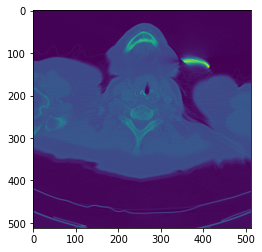

In [46]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(vol_arr[0])

In [ ]:
import csv
wine_path = path + "/data/p1ch4/tabular-wine/winequality-white.csv"
wineq_numpy = np.loadtxt(wine_path, dtype=np.float32, delimiter=";",skiprows=1)
wineq_numpy

array([[ 7.  ,  0.27,  0.36, ...,  0.45,  8.8 ,  6.  ],
       [ 6.3 ,  0.3 ,  0.34, ...,  0.49,  9.5 ,  6.  ],
       [ 8.1 ,  0.28,  0.4 , ...,  0.44, 10.1 ,  6.  ],
       ...,
       [ 6.5 ,  0.24,  0.19, ...,  0.46,  9.4 ,  6.  ],
       [ 5.5 ,  0.29,  0.3 , ...,  0.38, 12.8 ,  7.  ],
       [ 6.  ,  0.21,  0.38, ...,  0.32, 11.8 ,  6.  ]], dtype=float32)

In [ ]:
col_list = next(csv.reader(open(wine_path), delimiter=';'))
wineq_numpy.shape, col_list

((4898, 12),
 ['fixed acidity',
  'volatile acidity',
  'citric acid',
  'residual sugar',
  'chlorides',
  'free sulfur dioxide',
  'total sulfur dioxide',
  'density',
  'pH',
  'sulphates',
  'alcohol',
  'quality'])

In [ ]:
wineq = torch.from_numpy(wineq_numpy)
wineq.shape, wineq.dtype

(torch.Size([4898, 12]), torch.float32)

In [ ]:
data = wineq[:, :-1] #마지막이 score column
data, data.shape

(tensor([[ 7.0000,  0.2700,  0.3600,  ...,  3.0000,  0.4500,  8.8000],
         [ 6.3000,  0.3000,  0.3400,  ...,  3.3000,  0.4900,  9.5000],
         [ 8.1000,  0.2800,  0.4000,  ...,  3.2600,  0.4400, 10.1000],
         ...,
         [ 6.5000,  0.2400,  0.1900,  ...,  2.9900,  0.4600,  9.4000],
         [ 5.5000,  0.2900,  0.3000,  ...,  3.3400,  0.3800, 12.8000],
         [ 6.0000,  0.2100,  0.3800,  ...,  3.2600,  0.3200, 11.8000]]),
 torch.Size([4898, 11]))

In [ ]:
target = wineq[:, -1]
target, target.shape

(tensor([6., 6., 6.,  ..., 6., 7., 6.]), torch.Size([4898]))

In [ ]:
# Tabular data 전처리
data_mean = torch.mean(data, dim=0)

data_var = torch.var(data, dim=0)

data_normalized = (data - data_mean) / torch.sqrt(data_var)

data_normalized

tensor([[ 1.7209e-01, -8.1764e-02,  2.1325e-01,  ..., -1.2468e+00,
         -3.4914e-01, -1.3930e+00],
        [-6.5743e-01,  2.1587e-01,  4.7991e-02,  ...,  7.3992e-01,
          1.3467e-03, -8.2418e-01],
        [ 1.4756e+00,  1.7448e-02,  5.4378e-01,  ...,  4.7502e-01,
         -4.3677e-01, -3.3662e-01],
        ...,
        [-4.2042e-01, -3.7940e-01, -1.1915e+00,  ..., -1.3131e+00,
         -2.6152e-01, -9.0544e-01],
        [-1.6054e+00,  1.1666e-01, -2.8253e-01,  ...,  1.0048e+00,
         -9.6250e-01,  1.8574e+00],
        [-1.0129e+00, -6.7703e-01,  3.7852e-01,  ...,  4.7502e-01,
         -1.4882e+00,  1.0448e+00]])

In [ ]:
#Finding Thresholds
bad_indexes = target <= 3 # 참거짓으로 결과가 나옴
bad_indexes.shape, bad_indexes.dtype, bad_indexes.sum() #이하의 개수
# 이런식으로 score점수로 우리가 카테고리화 할 수 있음

(torch.Size([4898]), torch.bool, tensor(20))

In [ ]:
bad_data = data[bad_indexes]
bad_data.shape, bad_data

(torch.Size([20, 11]),
 tensor([[8.5000e+00, 2.6000e-01, 2.1000e-01, 1.6200e+01, 7.4000e-02, 4.1000e+01,
          1.9700e+02, 9.9800e-01, 3.0200e+00, 5.0000e-01, 9.8000e+00],
         [5.8000e+00, 2.4000e-01, 4.4000e-01, 3.5000e+00, 2.9000e-02, 5.0000e+00,
          1.0900e+02, 9.9130e-01, 3.5300e+00, 4.3000e-01, 1.1700e+01],
         [9.1000e+00, 5.9000e-01, 3.8000e-01, 1.6000e+00, 6.6000e-02, 3.4000e+01,
          1.8200e+02, 9.9680e-01, 3.2300e+00, 3.8000e-01, 8.5000e+00],
         [7.1000e+00, 3.2000e-01, 3.2000e-01, 1.1000e+01, 3.8000e-02, 1.6000e+01,
          6.6000e+01, 9.9370e-01, 3.2400e+00, 4.0000e-01, 1.1500e+01],
         [6.9000e+00, 3.9000e-01, 4.0000e-01, 4.6000e+00, 2.2000e-02, 5.0000e+00,
          1.9000e+01, 9.9150e-01, 3.3100e+00, 3.7000e-01, 1.2600e+01],
         [1.0300e+01, 1.7000e-01, 4.7000e-01, 1.4000e+00, 3.7000e-02, 5.0000e+00,
          3.3000e+01, 9.9390e-01, 2.8900e+00, 2.8000e-01, 9.6000e+00],
         [7.9000e+00, 6.4000e-01, 4.6000e-01, 1.0600e+01, 2

In [ ]:
bad_data = data[target <= 3]
mid_data = data[(target > 3) & (target < 7)]
good_data = data[target >= 7]

bad_mean = torch.mean(bad_data, dim=0)
mid_mean = torch.mean(mid_data, dim=0)
good_mean = torch.mean(good_data, dim=0)

for i, args in enumerate(zip(col_list, bad_mean, mid_mean, good_mean)):
  print('{:2} {:20} {:6.2f} {:6.2f} {:6.2f}'.format(i, *args)) #args 전체를 순서대로

 0 fixed acidity          7.60   6.89   6.73
 1 volatile acidity       0.33   0.28   0.27
 2 citric acid            0.34   0.34   0.33
 3 residual sugar         6.39   6.71   5.26
 4 chlorides              0.05   0.05   0.04
 5 free sulfur dioxide   53.33  35.42  34.55
 6 total sulfur dioxide 170.60 141.83 125.25
 7 density                0.99   0.99   0.99
 8 pH                     3.19   3.18   3.22
 9 sulphates              0.47   0.49   0.50
10 alcohol               10.34  10.26  11.42


In [ ]:
total_sulfur_threshold = 141.83
total_sulfur_data = data[:,6]
predicted_indexes = torch.lt(total_sulfur_data, total_sulfur_threshold)
predicted_indexes.shape, predicted_indexes.dtype, predicted_indexes.sum()

(torch.Size([4898]), torch.bool, tensor(2727))

In [ ]:
actual_indexes = target > 5
actual_indexes.shape, actual_indexes.dtype, actual_indexes.sum()

(torch.Size([4898]), torch.bool, tensor(3258))